In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy import interpolate

In [3]:
#digits dataset for input samples
def extract_dataset(f):
    data = []
    for line in f:
        if (line.split()[0] == "1.0000"):
            data.append(line.split())
        elif(line.split()[0] == "5.0000"):
            data.append(line.split())

    #changing the values of 5.0000 to -1 and 1.0000 the value of 1
    df = pd.DataFrame(data)
    df[0] = df[0].replace(["1.0000","5.0000"],[1,-1])
    
    for col in df.columns:
        df[col] = df[col].astype(float)

    features, rows, cols = extract_features(df)
    
    return features, rows, cols, df[0].astype(int)

def extract_features(df):
    rows, cols = df.shape
    features = np.zeros(shape = (rows,3))
    
    df1 = df.copy()
    df1 = df1.drop(0,axis=1)
    
    #extracting the intensity from the dataset
    for i in range(rows):
        mean_int = df1.loc[i,0:255].mean()
        features[i][0] = 1
        features[i][1] = mean_int
    

    flipped_df = df.loc[:, :1:-1]
    flipped_df.columns = df1.columns
    diff = pd.DataFrame()
    diff = abs(df1.subtract(flipped_df))
    
    #extracting the symmetry from the dataset
    for i in range(rows):
        mean_sym = diff.loc[i,0:255].mean()
        features[i][0] = 1
        features[i][2] =  mean_sym*-1

    return features, rows, cols

In [9]:
def bar_plot(cv_error, in_sample_error):
    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(cv_error))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, cv_error, color='steelblue', width=barWidth, edgecolor='white', label='cv_error')
    plt.bar(r2, in_sample_error, color='darksalmon', width=barWidth, edgecolor='white', label='in_sample_error')

    # Add xticks on the middle of the group bars
    plt.ylabel('Error', fontweight='bold')
    plt.xlabel('Regularization parameter', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(cv_error))], [0.01, 0.1, 1, 10, 100])
    plt.title("When C is very low, the model unerfits the data. As C increases, E_cv and E_in are similar.")


    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [5]:
f_train = open("/Users/bharathi/Documents/Digits/ZipDigits.train", "r")
X, rows, cols, y = extract_dataset(f_train)

f_test = open("/Users/bharathi/Documents/Digits/ZipDigits.test", "r")
X_testdata, test_rows, test_cols, y_testdata = extract_dataset(f_test)

### Problem 5.1

#### SVM classifier using the linear kernel

        CV Error  In-sample Error
C                                
0.01    0.103764         0.080077
0.10    0.026899         0.026906
1.00    0.021144         0.022422
10.00   0.022424         0.023062
100.00  0.021783         0.021781

C:  1.0   CV Error:  0.02114360612763171


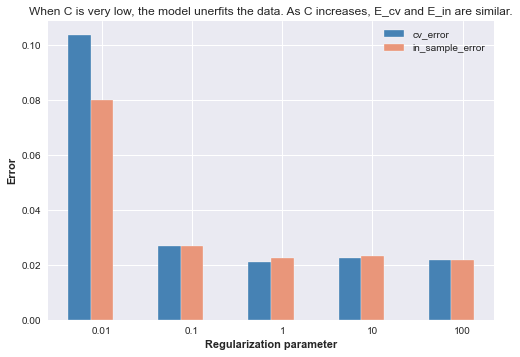

In [10]:
linear_kernel = pd.DataFrame()
linear_kernel['C'] = [0.01, 0.1, 1, 10, 100]
linear_kernel = linear_kernel.set_index('C')
cv_error = []
ein = []

for c,row in linear_kernel.iterrows():
    clf = SVC(kernel='linear', C=c)
    score = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    cv_error.append(np.mean(1-score))
    
    clf.fit(X, y)
    y_pred = clf.predict(X)
    accuracy = sklearn.metrics.accuracy_score(y, y_pred)
    ein.append(1 - accuracy)
    
linear_kernel['CV Error'], linear_kernel['In-sample Error'] = cv_error, ein
print(linear_kernel)
print()
print("C: ", linear_kernel['CV Error'].idxmin(), "  CV Error: ",linear_kernel['CV Error'].min())
bar_plot(linear_kernel['CV Error'], linear_kernel['In-sample Error'])

#### SVM classifier using the RBF kernel

        CV Error  In-sample Error
C                                
0.01    0.078781         0.062780
0.10    0.026257         0.023062
1.00    0.021144         0.022422
10.00   0.021785         0.022422
100.00  0.024341         0.022422

C:  1.0   CV Error:  0.02114360612763171


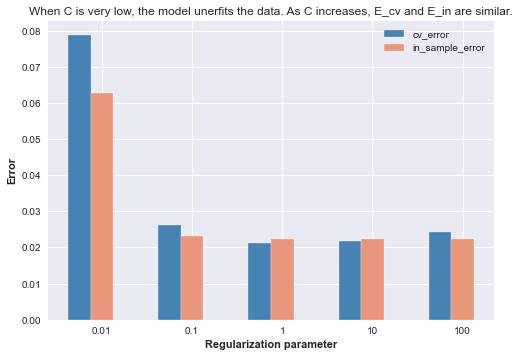

In [11]:
rbf_kernel = pd.DataFrame()
rbf_kernel['C'] = [0.01, 0.1, 1, 10, 100]
rbf_kernel = rbf_kernel.set_index('C')
cv_error = []
ein = []

for c,row in rbf_kernel.iterrows():
    clf = SVC(kernel='rbf', C=c)
    score = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    cv_error.append(np.mean(1-score))

    clf.fit(X, y)
    y_pred = clf.predict(X)
    accuracy = sklearn.metrics.accuracy_score(y, y_pred)
    ein.append(1 - accuracy)

rbf_kernel['CV Error'], rbf_kernel['In-sample Error'] = cv_error, ein
print(rbf_kernel)
print()
print("C: ", rbf_kernel['CV Error'].idxmin(), "  CV Error: ",rbf_kernel['CV Error'].min())
bar_plot(rbf_kernel['CV Error'], rbf_kernel['In-sample Error'])

#### SVM classifier using the polynomial kernel with degree=3

        CV Error  In-sample Error
C                                
0.01    0.071097         0.062140
0.10    0.023695         0.020500
1.00    0.021785         0.022422
10.00   0.021785         0.022422
100.00  0.023702         0.022422

C:  1.0  CV Error:  0.02178463176865735


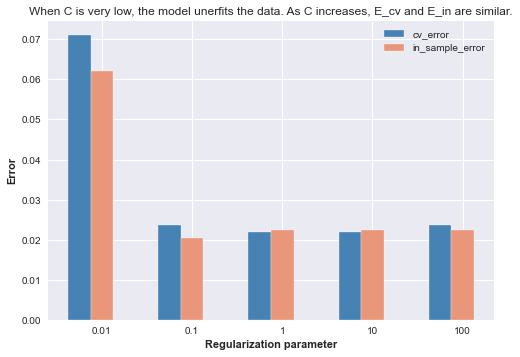

In [12]:
poly_kernel = pd.DataFrame()
poly_kernel['C'] = [0.01, 0.1, 1, 10, 100]
poly_kernel = poly_kernel.set_index('C')
cv_error = []
ein = []

for c,row in poly_kernel.iterrows():
    clf = SVC(kernel='poly', C=c, degree=3)
    score = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    cv_error.append(np.mean(1-score))
    
    clf.fit(X, y)
    y_pred = clf.predict(X)
    accuracy = sklearn.metrics.accuracy_score(y, y_pred)
    ein.append(1 - accuracy)
  
poly_kernel['CV Error'], poly_kernel['In-sample Error'] = cv_error, ein
print(poly_kernel)
print()
print("C: ", poly_kernel['CV Error'].idxmin(), " CV Error: ",poly_kernel['CV Error'].min())
bar_plot(poly_kernel['CV Error'], poly_kernel['In-sample Error'])

#### In-sample error for the best hypothesis

In [19]:
clf_final = SVC(C = 1, kernel='linear')
clf_final.fit(X, y)
y_pred = clf_final.predict(X)

accuracy = sklearn.metrics.accuracy_score(y, y_pred, normalize=True)
error_rate = 1 - accuracy
print("In-sample Error: ", error_rate)

In-sample Error:  0.022421524663677084


### Problem 5.2 - Test error for the best hypothesis

In [17]:
y_pred_test = clf_final.predict(X_testdata)
accuracy = sklearn.metrics.accuracy_score(y_testdata, y_pred_test)

print("Test error using the final hypothesis = ", 1-accuracy)

Test error using the final hypothesis =  0.04009433962264153


### Problem 5.3 - Comparison of models

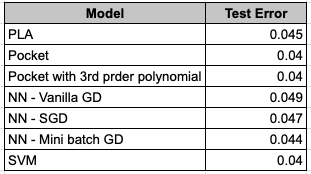

In [25]:
from IPython.display import Image
Image(filename='Etest_prob5.3.png', width = 350, height = 300)

### Problem 5.4

### Problem 5.5

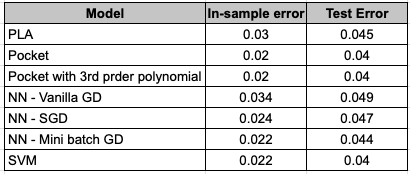

In [24]:
from IPython.display import Image
Image(filename='Ein_Prob5.5.png', width = 400, height = 350)